In [1]:
import numpy as np
import pandas as pd
import warnings; warnings.simplefilter('ignore')
# plotting
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model

In [2]:
#sqqq and tqqq are taken as IBdata feed not for SPXS 
path = '/home/octo/Dropbox/IQ_data/'
spy=pd.read_csv(path + 'SPY.csv',names = ["high", "low", "open","close","total_volume","volume"],index_col=0, parse_dates=True)
sqqq= pd.read_csv(path + 'SQQQ.csv',names = ["high", "low", "open","close","total_volume","volume"],index_col=0, parse_dates=True)
tqqq=pd.read_csv(path + 'TQQQ.csv',names = ["high", "low", "open","close","total_volume","volume"],index_col=0, parse_dates=True)
spy=spy.tail(140000)
sqqq=sqqq.tail(140000)
tqqq=tqqq.tail(140000)

In [3]:
#df for datascience
df=pd.DataFrame(data=spy.open)

In [4]:
#df['time']=df.index.strftime('%H:%M:%S')
time=df.index.strftime('%H:%M:%S')

In [5]:
# difference at '09:30:05' from last day close
EO=np.where(time=='09:30:05',df.open-spy.close.shift(1),0)
df['EO']=np.where(time=='09:30:05',df.open-spy.close.shift(1),0)     
df['EO']=df.EO.replace(to_replace=0, method='ffill')

In [6]:
H=pd.rolling_max(spy.high,4600)
L=pd.rolling_min(spy.low,4600)
M=(H+L)/2
df['OF']=np.where(time=='09:30:05',df.open,0)
df['OF']=df.OF.replace(to_replace=0, method='ffill')
df['HF']=np.where(time=='09:30:05',H,0)
df['HF']=df.HF.replace(to_replace=0, method='ffill')
df['LF']=np.where(time=='09:30:05',L,0)
df['LF']=df.LF.replace(to_replace=0, method='ffill')
df['MF']=np.where(time=='09:30:05',M,0)
df['MF']=df.MF.replace(to_replace=0, method='ffill')
df['OD']=df.open-df.OF

In [7]:
#SEntiment at start

df['S']=np.where(df.EO>0.25,1,np.where(df.EO<-0.25,-1,0))

#SEntiment now

df['Sn']=np.where(df.OD>0,1,np.where(df.OD<0,-1,0))

#SEntiment reversed if change is 1/4 

df['Srev']=np.where(df.OD/df.EO<-0.25,1,0)

#SEntiment stronger if change is 1/4 

df['S_strong']=np.where(df.OD/df.EO>0.25,1,0)

In [8]:
#market state atn start

df['MS']=np.where(df.OF>df.HF,4,np.where(df.OF>df.MF,3,np.where(df.OF<df.MF,2,np.where(df.OF<df.LF,1,0))))

In [9]:
#market state now

MSn=np.where(df.open>df.HF,4,np.where(df.open>df.MF,3,np.where(df.open<df.HF,2,np.where(df.open<df.LF,1,0))))
MSch=MSn-df['MS']

In [10]:
df['MSch']=np.where(MSch>0,1,np.where(MSch<0,-1,0))

## Market state change will contunue or will reverse ?
#### Sentiment reversal causes -ve market change and stronger sentiment causes +ve market change 

In [11]:
df_ms=pd.DataFrame(data=spy.open)
df_ms['MSch']=df.MSch
df_ms['S_rev']=df.Srev
df_ms['S_strong']=df.S_strong

In [12]:
# reversal, when market up or down
NL=pd.rolling_sum(pd.DataFrame(data=spy.open-spy.close.shift(60)),12)
NLqtop=pd.rolling_quantile(NL,720,.7)
NLqbot=pd.rolling_quantile(NL,720,.3)
df['R']=np.where(NL>NLqtop,1,np.where(NL<NLqbot,-1,0)) # only considering 1 and 0

In [13]:
df['speed']=pd.rolling_sum(pd.DataFrame(data=(spy.open-spy.close.shift(1))),60)
speedQtop=pd.rolling_quantile(df.speed,1000,.7)
speedQbot=pd.rolling_quantile(df.speed,1000,.3)
df['speedB']=np.where(df.speed>speedQtop,1,np.where(df.speed<speedQbot,-1,0))

In [14]:
P=(spy.high+spy.low+spy.close)/3
vwap=pd.rolling_sum(spy.volume*P,12)/pd.rolling_sum(spy.volume,12)
df['spread']=pd.rolling_sum(pd.DataFrame(data=(spy.open-vwap)),60)
spreadqtop=pd.rolling_quantile(df.spread,1000,.7)
spreadqbot=pd.rolling_quantile(df.spread,1000,.3)
df['spreadB']=np.where(df.spread>spreadqtop,1,np.where(df.spread<spreadqbot,-1,0))

In [15]:
df_ms=pd.DataFrame(data=spy.open)
df_ms['MSch']=df.MSch
df_ms['S_rev']=df.Srev
df_ms['S_strong']=df.S_strong
df_ms['R']=df.R
df_ms['speedB']=df.speedB
df_ms['spreadB']=df.spreadB

In [16]:
p60=pd.DataFrame(data=spy.close.shift(60))
df=df.tail(130000)
df_ms=df_ms.tail(130000)

In [17]:
# Create linear regression object
regr = linear_model.LinearRegression()
# Train the model using the training sets
regr.fit(pd.DataFrame(spy.open.tail(130000)),pd.DataFrame(p60.tail(130000)))
df['pr']=regr.predict(pd.DataFrame(p60.tail(130000)))

In [18]:
err=df.open-df.pr
errQtop=pd.rolling_quantile(err,1000,.8)
errQbot=pd.rolling_quantile(err,1000,.2)
df['err']=np.where(err>errQtop,1,np.where(err<errQbot,-1,0))

In [19]:
df=df.dropna()

In [20]:
df_ms['e']=df['err']

In [21]:
df_ml=df_ms

# Machine Learning

In [22]:
# reduce dataset based Market state change
df_ml=df_ml[df_ml.MSch!=0] # all decision when volume above 30% or vol==1
df_ml=df_ml.dropna()

In [23]:
len(df_ml)

63589

In [24]:
len(df)

130000

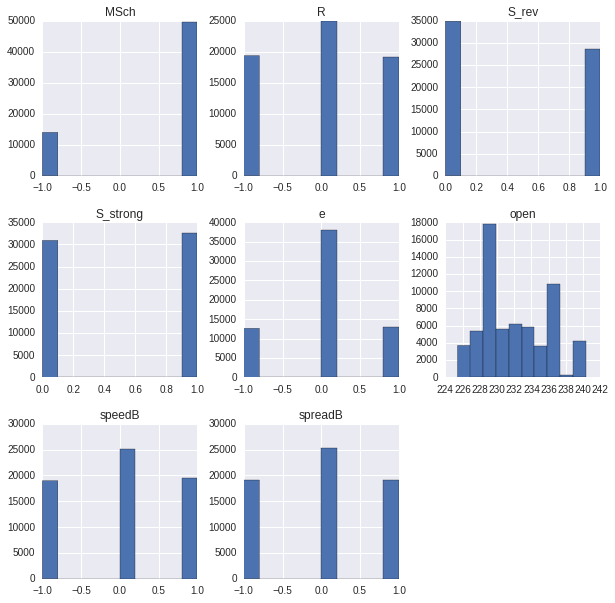

In [25]:
pd.DataFrame.hist(df_ml, figsize = [10,10]);

In [27]:
#X=pd.DataFrame(df_svm[['volume_u','volume_d','ret_p','ret_n','Volatility','momentum','RSI']])
X=pd.DataFrame(df_ml[['speedB','spreadB','e','S_strong','R','S_rev']])
y=pd.DataFrame(df_ml[['MSch']])

In [28]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### SVM

In [29]:
from sklearn import svm
from sklearn.svm import SVC
svm = SVC(kernel='linear')
svm_model = svm.fit(X_train, y_train)
print('SVC accuracy for test set: %f' % svm_model.score(X_test, y_test))

/home/octo/anaconda2/envs/PyAlgo/lib/python2.7/site-packages/sklearn/svm/base.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y_ = column_or_1d(y, warn=True)


SVC accuracy for test set: 0.780862


In [30]:
from sklearn.metrics import classification_report
y_true, y_pred = y_test,svm_model.predict(X_test)
print(classification_report(y_true, y_pred))

             precision    recall  f1-score   support

         -1       0.50      0.42      0.46      2775
          1       0.85      0.88      0.86      9943

avg / total       0.77      0.78      0.77     12718



In [32]:
X1=pd.DataFrame(df_ml[['speedB','spreadB','e','S_strong','R','S_rev']]).tail(10)
svm_model.predict(X1)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [33]:
df_ml.MSch.tail(10)

2017-03-01 15:59:15    1
2017-03-01 15:59:20    1
2017-03-01 15:59:25    1
2017-03-01 15:59:30    1
2017-03-01 15:59:35    1
2017-03-01 15:59:40    1
2017-03-01 15:59:45    1
2017-03-01 15:59:50    1
2017-03-01 15:59:55    1
2017-03-01 16:00:00    1
Name: MSch, dtype: int64

### Logistics

In [34]:
from sklearn import linear_model
lm = linear_model.LogisticRegression(C=1e4)
lm_model= lm.fit(X_train, y_train)
print('Logistic Regression accuracy for test set: %f' % lm_model.score(X_test, y_test))

Logistic Regression accuracy for test set: 0.780862


/home/octo/anaconda2/envs/PyAlgo/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [35]:
from sklearn.metrics import classification_report
y_true, y_pred = y_test,lm_model.predict(X_test)
print(classification_report(y_true, y_pred))

             precision    recall  f1-score   support

         -1       0.50      0.40      0.45      2775
          1       0.84      0.89      0.86      9943

avg / total       0.77      0.78      0.77     12718



In [36]:
lm_model.predict(X1)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

### KNN

In [37]:
from sklearn import neighbors, linear_model
knn = neighbors.KNeighborsClassifier(n_neighbors = 5)
knn_model = knn.fit(X_train, y_train)
print('k-NN accuracy for test set: %f' % knn_model.score(X_test, y_test))

/home/octo/anaconda2/envs/PyAlgo/lib/python2.7/site-packages/ipykernel/__main__.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  app.launch_new_instance()


k-NN accuracy for test set: 0.773549


In [38]:
from sklearn.metrics import classification_report
y_true, y_pred = y_test, knn_model.predict(X_test)
print(classification_report(y_true, y_pred))

             precision    recall  f1-score   support

         -1       0.49      0.67      0.56      2775
          1       0.90      0.80      0.85      9943

avg / total       0.81      0.77      0.79     12718



In [39]:
knn_model.predict(X1)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

### Decision Tree

In [40]:
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier

In [41]:
dt = DecisionTreeClassifier()
dt_model=dt.fit(X_train, y_train)
print('Decison Tree accuracy for test set: %f' % dt_model.score(X_test, y_test))

Decison Tree accuracy for test set: 0.788410


In [42]:
from sklearn.metrics import classification_report
y_true, y_pred = y_test, dt_model.predict(X_test)
print(classification_report(y_true, y_pred))

             precision    recall  f1-score   support

         -1       0.52      0.47      0.49      2775
          1       0.86      0.88      0.87      9943

avg / total       0.78      0.79      0.78     12718



In [43]:
dt_model.predict(X1)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

### Naive Bayes

In [44]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb_model=gnb.fit(X_train, y_train)
print('Decison Tree accuracy for test set: %f' % gnb_model.score(X_test, y_test))

Decison Tree accuracy for test set: 0.755307


/home/octo/anaconda2/envs/PyAlgo/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [45]:
from sklearn.metrics import classification_report
y_true, y_pred = y_test, gnb_model.predict(X_test)
print(classification_report(y_true, y_pred))

             precision    recall  f1-score   support

         -1       0.47      0.99      0.64      2775
          1       1.00      0.69      0.82      9943

avg / total       0.88      0.76      0.78     12718



In [46]:
gnb_model.predict(X1)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [49]:
df_ml1=df_ml

In [53]:
df_ml1['MSch1']=df_ml1.MSch.shift(1)
df_ml1=df_ml1.dropna()

In [55]:
df_ml1['MSchg']=df_ml1.MSch-df_ml1.MSch1

In [56]:
df_ml1.head()

,open,MSch,S_rev,S_strong,R,speedB,spreadB,e,MSch1,MSchg
2017-01-19 10:58:05,226.390,-1,1,0,-1,-1,-1,0,-1,0
2017-01-19 10:58:15,226.390,-1,1,0,-1,-1,-1,0,-1,0
2017-01-19 10:58:20,226.400,-1,1,0,-1,-1,-1,0,-1,0
2017-01-19 10:58:30,226.405,-1,1,0,-1,-1,-1,0,-1,0
2017-01-19 10:58:35,226.410,-1,1,0,-1,0,-1,0,-1,0


In [58]:
# reduce dataset based Market state change
df_ml1=df_ml1[df_ml1.MSchg!=0] # all decision when volume above 30% or vol==1
df_ml1=df_ml1.dropna()

In [59]:
len(df_ml1)

17

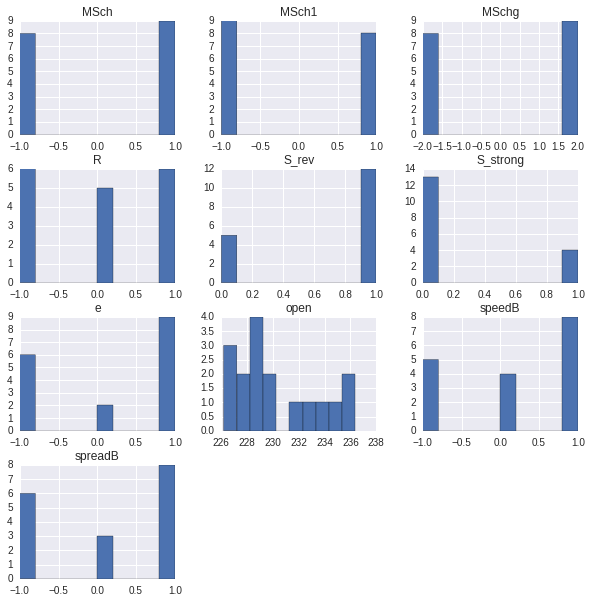

In [60]:
pd.DataFrame.hist(df_ml1, figsize = [10,10]);

In [61]:
df_ml1

,open,MSch,S_rev,S_strong,R,speedB,spreadB,e,MSch1,MSchg
2017-01-20 09:35:10,227.0500,1,0,1,1,1,1,1,-1,2
2017-01-20 12:31:40,226.1800,-1,1,0,-1,0,-1,-1,1,-2
2017-01-23 09:36:10,226.6300,1,1,0,1,1,1,1,-1,2
2017-01-27 09:31:55,229.3600,-1,1,0,1,1,1,1,1,-2
2017-02-01 09:30:20,228.3700,1,0,0,1,1,1,1,-1,2
2017-02-01 10:59:15,227.3100,-1,1,0,0,0,0,0,1,-2
2017-02-02 10:56:05,227.7800,1,1,0,0,1,0,1,-1,2
2017-02-06 13:17:50,228.6150,-1,0,1,-1,-1,-1,-1,1,-2
2017-02-07 09:45:35,229.5700,1,0,1,0,1,1,1,-1,2
2017-02-07 12:22:50,229.0400,-1,1,0,-1,-1,-1,-1,1,-2


## Conclusion 
###### (1) Sentiment reverses by 25% (present price changes from opening price at 9:00:05 by 25% )of GAP[ open price-last closing price]
###### (2) Reversal [ price diference between 5 min adding to 1 min] if goes beyond limit . If positive then positive change, negative for negative change.
###### (3) High speed for positive change and low speed for negative change 
###### (4) Diference of open price and VWAP. If positive then positive change, negative for negative change. 
###### (5) Diference of open price and regressive predicted value. If positive then positive change, negative for negative change.

## if 3 out of 5 signals confirm then state change is expected 